In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
pd.options.mode.chained_assignment = None  # default='warn'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# plot styles
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [41]:
result=pd.read_csv('result')

In [5]:
#This data after cleaning missig values and others. 
clean_data=pd.read_csv('clean_data_for_nlp')

In [6]:
# Tokenizer and lemmatizer will dealing with texts
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [7]:
clean_data.columns

Index(['index', 'Drivetrain', 'Engine', 'Exterior Color', 'Fuel Type',
       'Interior Color', 'Mileage', 'Transmission', 'price', 'text_blobs',
       'Make', 'Model', 'ModelYear', 'PlantCountry'],
      dtype='object')

In [8]:
# clean_data.Make.value_counts()

# Preprocessing 

In [9]:
clean_data['Model'] = clean_data.Model.map(lambda row: str(row).lower())

clean_data['ModelYear'] = clean_data.ModelYear.map(lambda row: str(row))

clean_data=clean_data.drop(clean_data.ModelYear[clean_data.ModelYear=='nan'].index)

clean_data['ModelYear'] = clean_data.ModelYear.map(lambda row: float(row))

clean_data['ModelYear'] = clean_data.ModelYear.map(lambda row: int(row))

clean_data['ModelYear'] = clean_data.ModelYear.map(lambda row: str(row))

clean_data['Model'] = clean_data.apply(lambda row: re.sub( 'mazda6','mx-6', row['Model']), axis=1)

clean_data['m_y'] = clean_data.apply(lambda row:row['Model']+row['ModelYear'], axis=1)

clean_data['text_blobs'] = clean_data.apply(lambda row: tokenizer.tokenize(row['text_blobs']), axis=1)

clean_data['text_blobs'] = clean_data.apply(lambda row: [lemmatizer.lemmatize(i).lower() for i in row['text_blobs']], axis=1)

clean_data['joined_text'] = clean_data['text_blobs'].apply(lambda x: " ".join(x))

# Building features

In [377]:
#Builgind features using some important specification
clean_data['brakes'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='brakes' or i=='brake']), axis=1)
clean_data['airbag'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='airbag' or i=='airbags']), axis=1)
clean_data['camera'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='cameras' or i=='camera']), axis=1)
clean_data['video'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='audio' or i=='audios']), axis=1)
clean_data['speakers'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='speakers' or i=='speaker']), axis=1)
clean_data['controls'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='control' or i=='controls']), axis=1)
clean_data['bluetooth'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='bluetooths' or i=='bluetooths']), axis=1)
clean_data['alarm'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='alarms' or i=='alarm']), axis=1)
clean_data['navigations'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='navi' 
                                                            or i=='gps' or i=='compass']), axis=1)
clean_data['digital'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='digitals' or i=='digital']), axis=1)
clean_data['keyless'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='keyless']), axis=1)
clean_data['heated'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='heated']), axis=1)
clean_data['leather'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='leather' or i=='leathers']), axis=1)
clean_data['armrest'] = clean_data.apply(lambda x: len([i for i in x['text_blobs'] if i=='armrest' or i=='armrests']), axis=1)
clean_data['total'] = clean_data.apply(lambda x: len([i for i in x['text_blobs']]), axis=1)

In [414]:
# built feature using some key words and dropped all others and concatenate again 
df_built_feature=clean_data.drop(['index', 'Drivetrain', 'Fuel Type', 'Mileage', 'Transmission', 'price',
       'Make', 'Model', 'ModelYear','Engine','m_y','joined_text', 'Exterior Color', 
                                  'Interior Color', 'text_blobs', 'safety','PlantCountry'], axis=1)

# NPL approach: feature extraction using td_idf on text column

In [23]:
corpus=clean_data.text_blobs

In [189]:
tf_vectorizer = TfidfVectorizer(ngram_range=(2,4),
                               min_df = 0, max_features=30)

In [190]:
tfidf_matrix = tf_vectorizer.fit_transform(clean_data['joined_text'])

In [191]:
tfidf_matrix.todense()

matrix([[ 0.15380795,  0.34844431,  0.        , ...,  0.23491745,
          0.        ,  0.        ],
        [ 0.16195632,  0.18345202,  0.        , ...,  0.43288492,
          0.12723148,  0.23317836],
        [ 0.1583981 ,  0.17942154,  0.        , ...,  0.36289228,
          0.12443617,  0.22805537],
        ..., 
        [ 0.5148551 ,  0.        ,  0.        , ...,  0.        ,
          0.40446571,  0.        ],
        [ 0.5148551 ,  0.        ,  0.        , ...,  0.        ,
          0.40446571,  0.        ],
        [ 0.5148551 ,  0.        ,  0.        , ...,  0.        ,
          0.40446571,  0.        ]])

In [192]:
df= pd.DataFrame(tfidf_matrix.todense(),
                   columns=tf_vectorizer.get_feature_names())

In [193]:
df.head()

,abs brakes,adjustment power,air bag,air conditioning,am fm,audio system,cd player,control on,control on steering,control on steering wheel,...,on steering wheel,passenger mirror,power door,power remote,power steering,rear seat,stability control,steering wheel,traction control,vanity mirror
0,0.153808,0.348444,0.0,0.135429,0.124542,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.340070,0.119639,0.348444,0.139261,0.000000,0.000000,0.234917,0.000000,0.000000
1,0.161956,0.183452,0.0,0.142604,0.196709,0.000000,0.165721,0.189091,0.189446,0.189599,...,0.152962,0.089521,0.125977,0.275178,0.146639,0.333699,0.132922,0.432885,0.127231,0.233178
2,0.158398,0.179422,0.0,0.209206,0.192387,0.282228,0.000000,0.184937,0.185284,0.185433,...,0.149602,0.175109,0.123209,0.269132,0.143417,0.163184,0.130002,0.362892,0.124436,0.228055
3,0.102014,0.115554,0.0,0.089824,0.165206,0.242354,0.208771,0.238212,0.238659,0.238852,...,0.192698,0.225554,0.079351,0.231108,0.092366,0.000000,0.083726,0.311621,0.160283,0.097917
4,0.000000,0.000000,0.0,0.000000,0.000000,0.341087,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.223356,0.000000,0.000000,0.000000,0.471341,0.438573,0.451162,0.000000


In [29]:
clean_data.columns

Index(['index', 'Drivetrain', 'Engine', 'Exterior Color', 'Fuel Type',
       'Interior Color', 'Mileage', 'Transmission', 'price', 'text_blobs',
       'Make', 'Model', 'ModelYear', 'PlantCountry', 'm_y', 'joined_text'],
      dtype='object')

In [30]:
model_data=clean_data.drop(['Engine','text_blobs','joined_text'], axis=1)

In [31]:
model_data.head()

,index,Drivetrain,Exterior Color,Fuel Type,Interior Color,Mileage,Transmission,price,Make,Model,ModelYear,PlantCountry,m_y
0,0,RWD,Renaissance Red,Gasoline,Black,"89,843",automatic,"28,800",TOYOTA,supra,1994,Japan,supra1994
1,4,FWD,Polished Slate,Gasoline,Black,"102,685",automatic,"5,999",MAZDA,mx-6,2012,United States (USA),mx-62012
2,5,RWD,Red,Gasoline,Black,"13,793",automatic,"176,500",ASTON MARTIN,db11,2017,United Kingdom (UK),db112017
3,6,RWD,Blue,Gasoline,Black,"41,050",automatic,"34,695",BMW,m5,2013,Germany,m52013
4,7,RWD,Bianco Avus,Gasoline,Nero,"2,592",automatic,"429,800",FERRARI,458 speciale,2015,Italy,458 speciale2015


In [38]:
def bleach(string):
    string=str(string)
    new_string = ''
    include = '12345667890.'
    for i in string:
        if i in include:
            new_string+=i
    return int(new_string)

In [67]:
model_data['price'] = model_data['price'].map(bleach)

In [68]:
model_data['price'] = model_data.price.map(lambda row: float(row))

In [62]:
model_data['Mileage'] = model_data['Mileage'].map(bleach)

In [63]:
model_data['Mileage'] = model_data.Mileage.map(lambda row: float(row))

In [57]:
model_data['ModelYear'] = model_data.ModelYear.map(lambda row: float(row))

In [53]:
model_data=clean_data.drop(['Engine','text_blobs','joined_text'], axis=1)

In [69]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

dataset_numeric = model_data.select_dtypes(include=numerics)

In [70]:
dataset_numeric.head()

,index,Mileage,price,ModelYear
0,0,89843.0,28800.0,1994.0
1,4,102685.0,5999.0,2012.0
2,5,13793.0,176500.0,2017.0
3,6,41050.0,34695.0,2013.0
4,7,2592.0,429800.0,2015.0


In [95]:
# All categorical dataset
nonnumeric  = ['object']
dataset_obj = model_data.select_dtypes(include=nonnumeric)

In [96]:
dataset_obj.head()

,Drivetrain,Exterior Color,Fuel Type,Interior Color,Transmission,Make,Model,PlantCountry,m_y
0,RWD,Renaissance Red,Gasoline,Black,automatic,TOYOTA,supra,Japan,supra1994
1,FWD,Polished Slate,Gasoline,Black,automatic,MAZDA,mx-6,United States (USA),mx-62012
2,RWD,Red,Gasoline,Black,automatic,ASTON MARTIN,db11,United Kingdom (UK),db112017
3,RWD,Blue,Gasoline,Black,automatic,BMW,m5,Germany,m52013
4,RWD,Bianco Avus,Gasoline,Nero,automatic,FERRARI,458 speciale,Italy,458 speciale2015


In [212]:
dataset_obj.to_csv('categorical.csv', index=False)

In [102]:
data_obj=dataset_obj.drop(['Exterior Color','Interior Color','PlantCountry','m_y'], axis=1)

In [104]:
data_obj_num=data_obj.apply(LabelEncoder().fit_transform)

In [117]:
data_obj_num.head()

,Drivetrain,Fuel Type,Transmission,Make,Model
0,3,3,0,50,421
1,2,3,0,31,314
2,3,3,0,3,152
3,3,3,0,6,287
4,3,3,0,12,32


In [501]:
ohe = OneHotEncoder()

In [503]:
# data_obj_num[feature] = le.fit_transform(data_obj_num[feature])
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = OneHotEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

In [512]:
def other_dummy_encode(df):
    list_of_dfs = []
    for i in df.columns:
        list_of_dfs.append(pd.get_dummies(df[i], prefix=i, prefix_sep='_'))
    new_df = pd.concat(list_of_dfs, axis=1)
    return new_df
    

In [513]:
dummied_out = other_dummy_encode(data_obj)

In [514]:
dummied_out.shape

(4247, 550)

In [515]:
dummied_out.head()

,Drivetrain_4WD,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD,Fuel Type_ Diesel,Fuel Type_ E85 Flex Fuel,Fuel Type_ Electric,Fuel Type_ Gasoline,Fuel Type_ Hybrid,Fuel Type_ Unknown,...,Model_xterra,Model_xts,Model_xv crosstrek,Model_yaris,Model_yukon,Model_yukon xl,Model_z3,Model_z4,Model_zdx,Model_zephyr
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [538]:
# from collections import defaultdict
# d = defaultdict(LabelEncoder)

In [539]:
# fit = df.apply(lambda x: d[x.name].fit_transform(x))

In [105]:
# fit.apply(lambda x: d[x.name].inverse_transform(x))

In [106]:
# df.apply(lambda x: d[x.name].transform(x))

In [251]:
categ=pd.read_csv('categ')

In [254]:
categ.drop(['Drivetrain', 'Exterior Color', 'Fuel Type', 'Interior Color',
       'Transmission', 'Make', 'Model', 'PlantCountry', 'm_y'], axis=1, inplace=True)

In [315]:
categ=categ.apply(LabelEncoder().fit_transform)

# Concat numeric, label, text data after EDA

Final model: numerical data, dummies of popular make and built features.

In [516]:
large=pd.concat([dataset_numeric,categ,dummied_out, df_built_feature], axis=1, join_axes=[model_data.index])

In [517]:
large.head()

,index,Mileage,price,ModelYear,make_is_CHEVROLET,make_is_FORD,make_is_BMW,make_is_TOYOTA,make_is_MERCEDES-BENZ,make_is_AUDI,...,video,bluetooth,alarm,navigations,digital,keyless,heated,leather,armrest,total
0,0,89843.0,28800.0,1994.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,2,1,0,145
1,4,102685.0,5999.0,2012.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,1,0,1,1,0,0,3,447
2,5,13793.0,176500.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,0,2,0,1,1,7,4,3,453
3,6,41050.0,34695.0,2013.0,0.0,0.0,1.0,0.0,0.0,0.0,...,6,0,0,0,1,1,6,4,0,375
4,7,2592.0,429800.0,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,3,0,405


In [519]:
large.to_csv("num_dummy_built_features", index=False)

In [518]:
large=large.dropna()

In [479]:
# large.isnull().sum()

In [520]:
X=large.drop('price', axis=1)
y=large[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [522]:
X_train.shape

(2844, 597)

# Modeling

RANDOMFOREST REGRESSOR

In [930]:
rf_for_built=RandomForestRegressor(max_depth=25, min_samples_leaf=4, n_estimators=45)

In [931]:
rf_for_built.fit(X_train, y_train)

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [932]:
rf_for_built.score(X_train, y_train)

0.38240618066053433

In [934]:
# rf_for_built.score(X_test, y_test)

In [539]:
rf_for_built.fit(X_train, np.log(y_train))

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [540]:
rf_for_built.score(X_train, np.log(y_train))

0.89727776589021724

In [541]:
rf_for_built.score(X_test, np.log(y_test))

0.72095699544407288

In [542]:
y_pred=rf_for_built.predict(X_test)

In [770]:
# plt.scatter(rf_for_built.predict(X_test), np.log(y_test), alpha=.5, s=1)

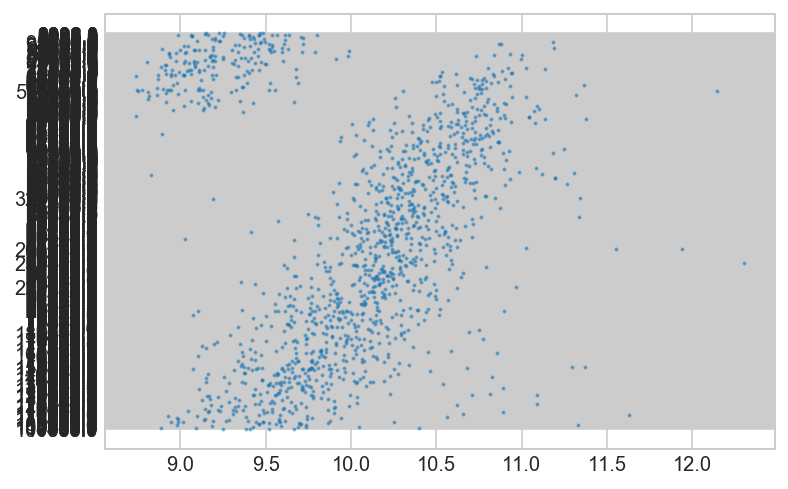

In [735]:
plt.scatter(y_pred, y_test, alpha=.5, s=1)

In [474]:
# This gridsearch for numeric data, categorical data and built features from text blobs. 

TUNING RANDOMFOREST REGRESSOR



In [545]:
rf_for_built=RandomForestRegressor(n_jobs=1)

param_grid = { 
           "n_estimators" : [38,40,45,50],
           "max_depth" : [22,25,26],
           "min_samples_leaf" : [5,6,7,8]
}
gs=GridSearchCV(rf_for_built, param_grid=param_grid)
gs.fit(X_train, np.log(y_train))
print(gs.best_score_)
print(gs.best_params_)

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

0.695676670641
{'max_depth': 26, 'min_samples_leaf': 5, 'n_estimators': 40}


In [666]:
est_for_built=GradientBoostingRegressor()

param_grid = { 
           "n_estimators" : [90,100,110],
           "max_depth" : [15,20,25],

}
gs=GridSearchCV(rf_for_built, param_grid=param_grid)
gs.fit(X_train, np.log(y_train))
print(gs.best_score_)
print(gs.best_params_)

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458:

0.754808306684
{'max_depth': 25, 'n_estimators': 110}


In [722]:
est = GradientBoostingRegressor(n_estimators=90, learning_rate=0.1,
     max_depth=5, random_state=0, loss='ls')

In [728]:
est.fit(X_train, y_train)

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=90, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [729]:
est.score(X_train, y_train)

0.9864031896973956

In [730]:
est.score(X_test, y_test)

0.78585630995965328

In [732]:
est.fit(X_train, np.log(y_train))

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=90, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [733]:
est.score(X_train, np.log(y_train))

0.89612195107318704

In [771]:
est.score(X_test, np.log(y_test))

0.81033716966262848

In [772]:
y_pred=est.predict(X_test)

In [738]:
mean_squared_error(y_test, est.predict(X_test))

1686210566.1173513

In [739]:
mean_squared_error(np.log(y_test), est.predict(X_test))

0.085377090507085321

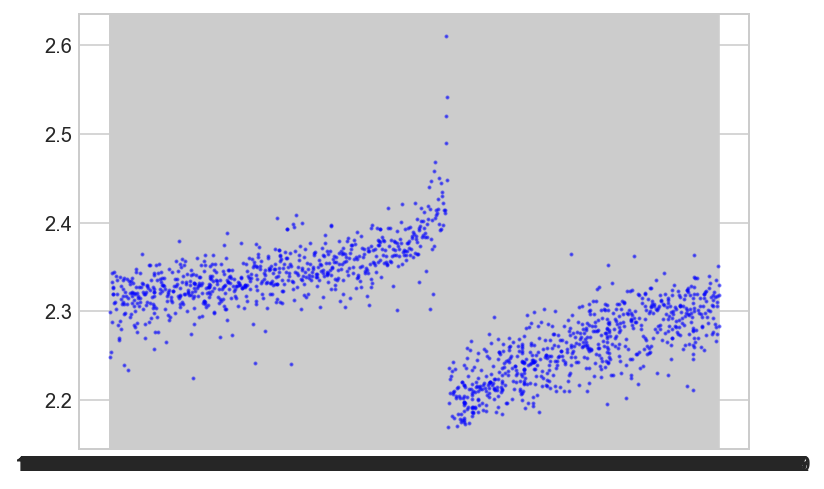

In [778]:
plt.scatter(np.log(y_test), np.log(y_pred), color='blue', alpha=.5, s=1)

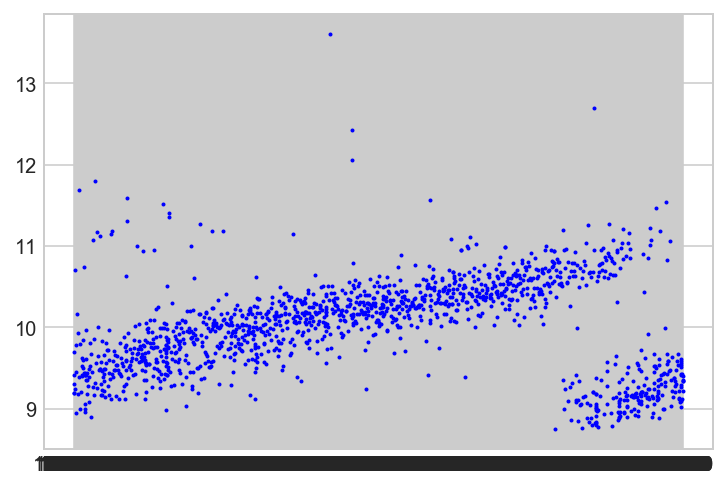

In [779]:
plt.scatter(y_test, y_pred, color='blue', s=1)

In [747]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostRegressor

In [766]:
clf = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)

In [749]:
scores = cross_val_score(clf, X_train, y_train)
scores.mean() 

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.20576898558298998

In [767]:
clf.fit(X_train, np.log(y_train))

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=100, random_state=None)

In [768]:
clf.score(X_train, np.log(y_train))

0.6064849848216568

In [769]:
clf.score(X_test, np.log(y_test))

0.56546667425734665

In [1009]:
price_filtered=large[large.price<40000]

In [1010]:
X=price_filtered.drop('price', axis=1)
y=price_filtered[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [1011]:
est_low = GradientBoostingRegressor(n_estimators=85, learning_rate=0.4,
     max_depth=4, random_state=0, loss='ls')

In [1012]:
est_low.fit(X_train, y_train)

/Users/enkhbat/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.4, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=85, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [1013]:
est_low.score(X_train, y_train)

0.92539051847230513

In [1014]:
est_low.score(X_test, y_test)

0.78874531068848908

In [1015]:
y_pred=est_low.predict(X_test)

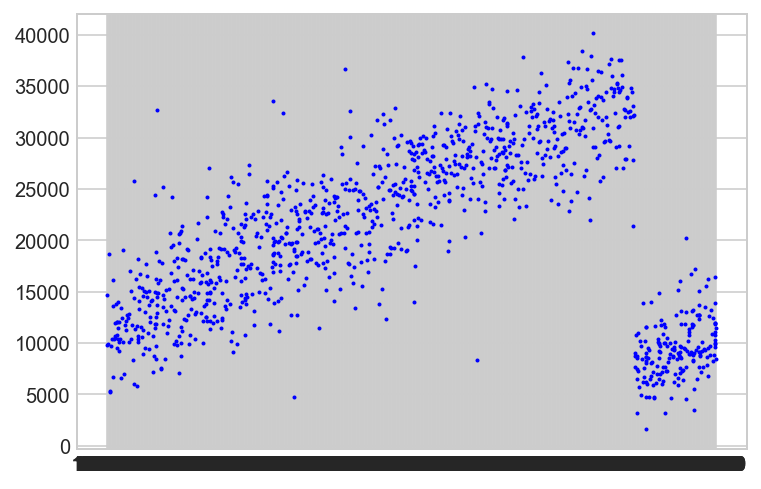

In [1016]:
plt.scatter(y_test, y_pred, color='blue', s=1)

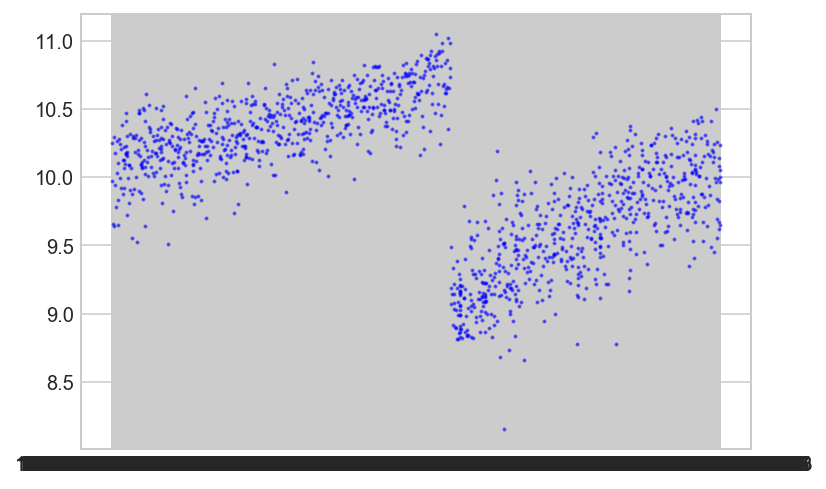

In [944]:
plt.scatter(np.log(y_test), np.log(y_pred), color='blue', alpha=.5, s=1)

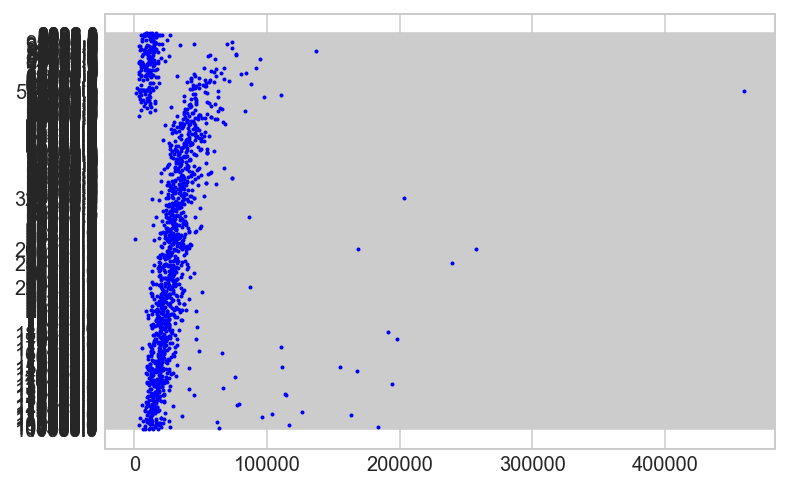

In [866]:
plt.scatter(y_pred,y_test, color='blue', s=1)

In [920]:
y_test['y_pred']=[x for x in y_pred]

In [922]:
y_test.describe()

,price,y_pred
count,1402.000000,1402.000000
mean,28395.849501,28949.265136
std,29683.441146,24821.047519
min,5000.000000,739.468250
25%,13990.000000,15928.634735
50%,22755.000000,25154.588950
75%,33999.750000,35009.674418
max,598800.000000,459768.903464


In [928]:
result=y_test[y_test.price<40000]

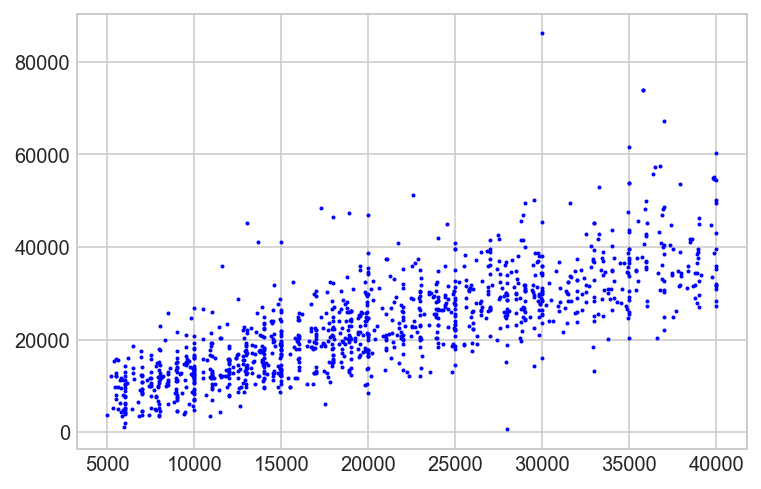

In [929]:
plt.scatter(result.price,result.y_pred, color='blue', s=1)

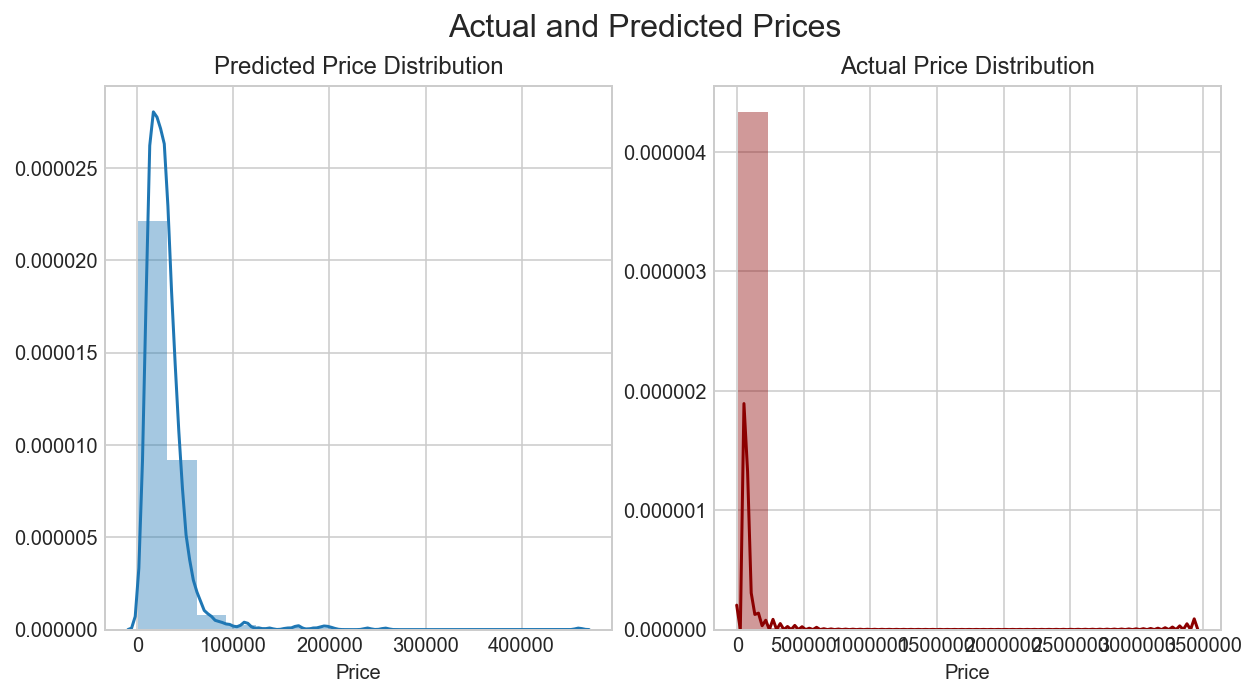

In [935]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle('Actual and Predicted Prices',fontsize=16)
# predicted
sns.distplot(y_pred,ax=ax[0], bins=15)
ax[0].set_title('Predicted Price Distribution')
ax[0].set_xlabel('Price')

# actual
sns.distplot(large.price,ax=ax[1], bins=15,color='darkred')
ax[1].set_title('Actual Price Distribution')
ax[1].set_xlabel('Price')

plt.show()

In [229]:
# from sklearn.linear_model import Lasso
# ls = Lasso(alpha = 0.001, max_iter = 100)
# ls.fit(X_train, y_train)

In [629]:
# X_train.head()

In [157]:
# def parse_transmission(x):
#     temp = ''
#     for i in ['city', 'highway']:
#         if i in x:
#             temp+=i
#     for j in range(10,30):
#         if str(j) in x:
#             temp+=" " +str(j)
#     return temp

In [156]:
# clean_data['fuel_consumption'] = clean_data['text_blobs'].map(parse_transmission)

In [218]:
# clean_data['fuel_consumption']

In [630]:
# gov=pd.read_csv('vehicles.csv')

In [631]:
# gov.columns

In [632]:
# cars=gov[[ 'fuelCost08', 'make','model', 'year','cylinders','UCity','UHighway']]

In [633]:
# cars.drop_duplicates(subset=['model' and 'year'])

In [634]:
# cars['model'] = cars.model.map(lambda row: str(row).lower())

# cars['make'] = cars.make.map(lambda row: str(row).lower())

# cars['mm'] = cars.apply(lambda row: row['make']+row['model'], axis=1)

# cars['mm'] = cars.m_y.map(lambda row: row.strip())

# cars

In [635]:
# cars.drop(['make','model','m_y'],axis=1, inplace=True)

In [588]:
# result=pd.read_csv('result')

In [597]:
result=result.replace('', np.nan, regex=True)

In [636]:
# result.Model=result.Model.map(lambda x: str(x))

# result.Make=result.Make.map(lambda x: str(x))

# result.ModelYear=result.ModelYear.map(lambda x: str(x))

In [637]:
# result['Make'] = dataset_obj.Make.map(lambda row: row.lower())

# result['Model'] = result.Model.map(lambda row: row.lower())

# result['mm'] = result.apply(lambda row: row['Make']+row['Model'], axis=1)
# result['mm'] = result.mm.map(lambda row: row.strip())
# result.head()


In [143]:
# cars[cars['make']=='Mazda']

In [144]:
# clean_data.head()

In [145]:
# plt.hist(clean_data['ModelYear'].astype(int), alpha=.5, color='blue')
# plt.hist(cars['year'].astype(int), alpha=.5, color='red')

In [607]:
# df=pd.merge(result, cars, on='mm', how='left')

# df=df.drop_duplicates(subset='VIN')

# df.tail()

# df.isnull().sum()

In [638]:
# car_set=set(cars['mm'].values)&set(result['mm'].values)

In [639]:
# set(result['mm'].values)-car_set

In [149]:
# df=df.drop_duplicates(subset=['Mileage','Model'])

In [150]:
# table = pd.pivot_table(cars, index=['make', 'model', 'year'], values=['fuelCost08','cylinders','UCity','UHighway','youSaveSpend'],aggfunc=np.mean)

In [151]:
# table.head()

In [147]:
# table = pd.pivot_table(clean_data, index=['Make', 'Model', 'ModelYear'],
#                        values=['price'])

In [152]:
# table.index.value_counts()

In [153]:
# table['model'] = table.index.map(lambda row: str(row).lower())